<p style="font-size:30px;">
Поиск и предложение похожих товаров
</p>

В нашем распоряжении данные о товарах от одного из крупнейших маркетплейсов страны.
Разработаем алгоритм, который для списка товаров `validation.csv` предложит 5 вариантов наиболее похожих товаров из другого списка `base.csv`. Оценка качества алгоритма будем проводить по метрике `accuracy@5`.

Данные:

- *`base.csv`* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- *`target.csv`* - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И `id` товара из *`base.csv`*, который максимально похож на него (по мнению экспертов).

- *`validation.csv`* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *`base.csv`*

- *`validation_answer.csv`* - правильные ответы к файлу `validation.csv`.

<p style="font-size:25px;">
Часть I. Использование методов поиска ближайших векторов из библиотеки Faiss
</p>

In [1]:
#!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import faiss

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

import datetime
# from google.colab import drive
# drive.mount('/content/drive/')

%matplotlib inline

## Загрузка данных

In [3]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [4]:
%%time
all_base = pd.read_csv('./datasets/base.csv', index_col=0, dtype=dict_base)
#all_base = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/matching/datasets/base.csv', index_col=0)

CPU times: user 19.9 s, sys: 816 ms, total: 20.7 s
Wall time: 20.7 s


In [5]:
all_train = pd.read_csv('./datasets/train.csv', index_col=0, dtype=dict_train)
valid_features = pd.read_csv('./datasets/validation.csv', index_col=0, dtype=dict_base)
valid_target = pd.read_csv('./datasets/validation_answer.csv', index_col=0)
# all_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/matching/datasets/train.csv', index_col=0)
# valid_features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projects/matching/datasets/validation.csv', index_col=0)

In [6]:
all_base.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.66634,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.20211,24.346846,179.937927,116.834000,-84.888939,-59.524609


In [7]:
all_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base


In [8]:
valid_features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319


In [9]:
all_base.shape

(2918139, 72)

In [10]:
all_train.shape

(100000, 73)

In [11]:
valid_features.shape

(100000, 72)

### Создадим подобные исходным подвыборки для тестирования алгоритмов и выбора оптимального решения

In [12]:
all_train['Target'].nunique()

91794

In [13]:
all_train['Target'].isin(all_base.index).sum()

100000

In [14]:
small_train = all_train.sample(10000, random_state=42)

In [15]:
small_base =  all_base[all_base.index.isin(small_train['Target'])]

In [16]:
base = pd.concat([small_base, all_base[~all_base.index.isin(all_train['Target'])].sample(300000, random_state=42)]).sort_index()

In [17]:
small_base.shape

(9895, 72)

In [18]:
base = small_base
train = small_train

## Baseline

### Создадим индексы

Зададим начальные условия, использовав исходные данные без обработки с количеством кластеров = 1

In [19]:
dim = base.shape[1]
n_cells = 1
top_n = 5

In [20]:
quantiser = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantiser, dim, n_cells)

index.train(np.ascontiguousarray(base.values).astype('float32'))
index.is_trained

index.add(np.ascontiguousarray(base.values).astype('float32'))

### Оценка результата работы алгоритма поиска

In [21]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

def accuracy_top_n(target_features, indices):
    acc = 0
    for target, el in zip(target_features.values.tolist(), indices.tolist()):
        acc += int(target in [base_index[r] for r in el])

    return 100 * acc / len(indices)

In [22]:
train_target = train['Target']
train_features = train.drop('Target', axis=1)

In [23]:
%%time
distances, indices = index.search(np.ascontiguousarray(train_features.values).astype('float32'), top_n)

CPU times: user 877 ms, sys: 22 µs, total: 877 ms
Wall time: 220 ms


In [24]:
accuracy_top_n(train_target, indices)

22.09

Значение метрики низкое. Требуется повышение качества поиска.

## Анализ данных и выбор оптимальных методов 

### Проверка на наличие дубликатов

In [25]:
print(base.duplicated().sum(), train_features.duplicated().sum())

0 0


Дубликаты отсутсвуют

**Основные характеристики**

In [26]:
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,...,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000,9895.000000
mean,-85.260506,7.674538,-44.006622,-145.900345,112.087029,-73.141373,-438.176758,21.757450,123.042282,126.835815,...,-81.289619,36.962170,-152.264725,14.042680,67.771362,23.180777,72.639366,115.240479,-716.929993,-47.931973
std,25.894461,4.963684,39.373257,20.640894,48.160267,28.902609,280.775452,66.759811,6.501996,64.710022,...,30.678225,25.227312,41.060852,98.478546,1.815911,55.601440,62.291691,21.532829,403.515045,41.134361
min,-175.377197,-11.559494,-211.055817,-219.098785,-76.023224,-170.541672,-791.469482,-247.546936,99.634750,-81.250565,...,-203.543915,-58.938324,-316.496307,-157.580673,61.245289,-175.645966,-173.424438,31.558434,-1297.872925,-184.794479
25%,-103.134533,4.342408,-69.749477,-159.716339,79.615791,-92.705673,-741.929413,-21.615194,118.670822,83.555286,...,-101.753189,20.135504,-179.564468,-71.395401,66.530823,-14.376081,31.211565,100.683414,-1074.464844,-76.326210
50%,-84.864510,7.685378,-42.446857,-145.725815,113.106796,-73.593338,-499.792786,22.696804,123.137756,126.793243,...,-80.825424,36.724640,-151.244537,15.063118,67.770370,23.117596,72.068954,115.315559,-819.584839,-48.189045
75%,-67.369076,10.972605,-17.928705,-131.685211,144.550705,-53.461758,-200.511978,67.253613,127.461132,171.084366,...,-60.639660,53.935606,-124.529079,99.261799,69.029846,60.245293,113.810776,129.914978,-368.498291,-19.976797
max,3.287636,26.251005,117.179115,-75.938217,283.793488,56.926674,109.526855,248.550674,146.868347,364.206970,...,36.147438,133.937500,-3.714294,185.066254,73.898117,250.648590,289.939453,190.536957,98.680695,91.918457


In [27]:
train_features.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-85.261772,7.631458,-43.852921,-145.842819,112.660477,-73.100487,-441.733337,21.936760,123.001587,126.366928,...,-81.308548,36.991806,-152.421646,15.453505,67.785439,22.486462,72.863831,115.197273,-717.038879,-48.079548
std,26.162254,4.969909,39.211796,20.477434,48.193996,28.991922,280.274475,66.225510,6.439504,64.801178,...,30.658936,25.332804,41.146439,98.804878,1.821194,56.341545,62.411190,21.446766,403.424927,40.948105
min,-175.377197,-11.560507,-204.783875,-218.798767,-74.233826,-163.993378,-791.469482,-278.582825,100.738213,-126.208099,...,-203.187988,-52.832024,-314.049866,-157.590103,61.025013,-179.519455,-153.667572,29.614471,-1297.479614,-193.639175
25%,-103.636671,4.226368,-69.518845,-159.270836,79.675457,-92.816296,-746.961884,-21.269200,118.668552,82.517776,...,-101.657814,19.997622,-179.817936,-69.152225,66.548975,-15.215783,31.814116,100.883371,-1074.464844,-76.030348
50%,-85.149399,7.659788,-42.749422,-145.863884,113.094601,-73.825802,-507.657562,23.173636,123.036602,127.437477,...,-80.774220,36.815573,-151.473907,15.295904,67.794895,22.646293,72.919739,115.405907,-822.102417,-48.813129
75%,-66.912569,11.015582,-17.897322,-131.872654,144.986702,-53.433932,-204.457546,66.714645,127.389118,170.194542,...,-60.741699,53.863308,-124.642365,101.921423,69.041912,59.348023,113.475615,129.612938,-368.282013,-20.271567
max,-0.370071,25.603153,105.971825,-77.269348,288.762970,45.868530,109.508156,248.550232,143.858963,371.604065,...,36.069984,127.843468,-4.602432,185.095139,73.850632,231.257355,299.943481,201.761261,98.680695,90.330841


**Построим гистограммы для каждого признака**

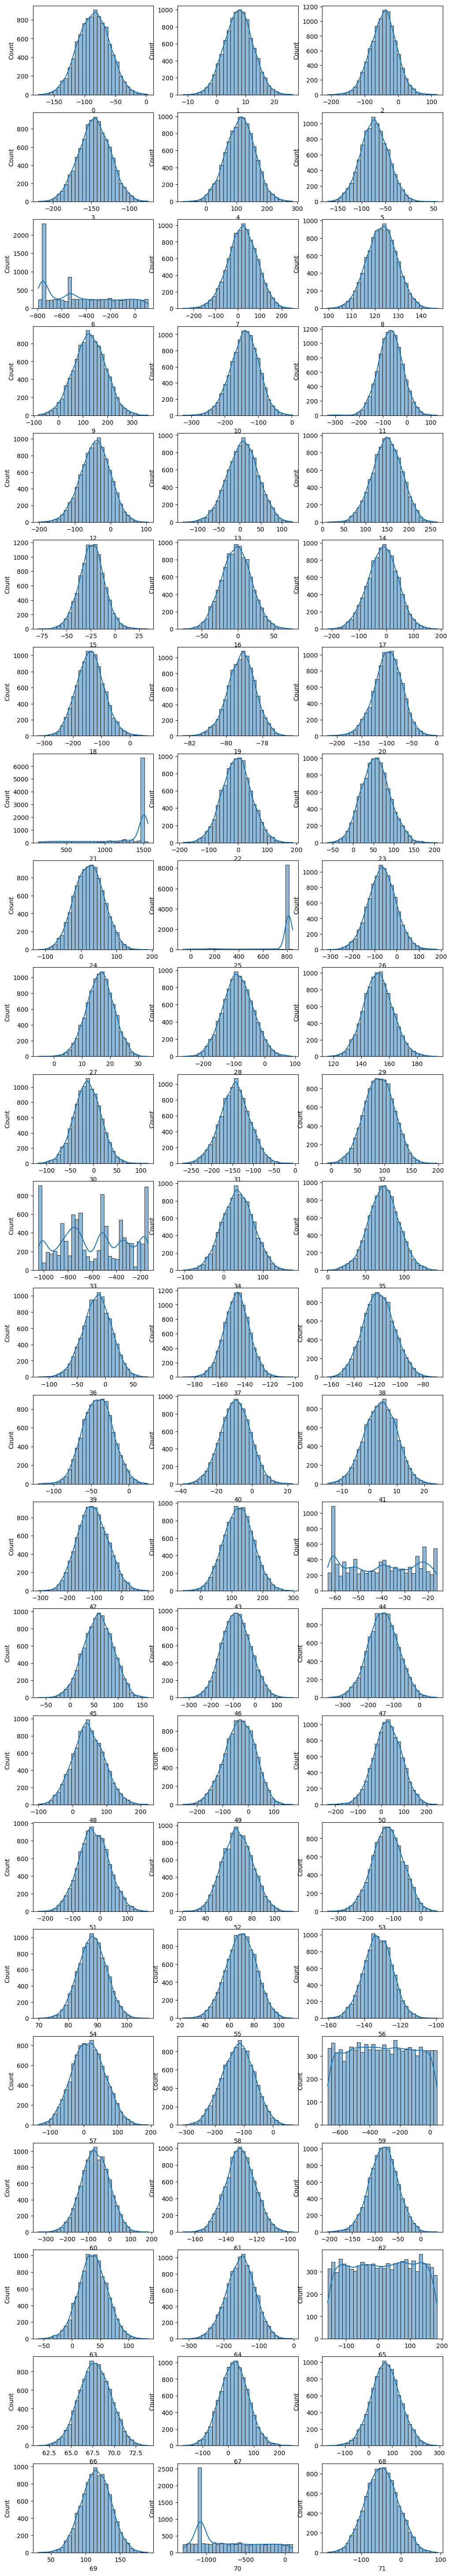

In [28]:
f, axs = plt.subplots(round(base.shape[1] / 3), 3, figsize=(12, 75))
j = 0
for i,  col in enumerate(base.columns):
    if (i%3 == 0) & (i != 0) : j += 1
    sns.histplot((base.iloc[:, i]), bins=30, kde=True, ax=axs[j, i%3]);

Большинство признаков, за исключением 6, 21, 25, 33, 44, 59, 65, 70 имеют нормальное распределениес различным средним и дисперсией.

Для проверки возможности повышения качества поиска целесообразно применить масштабирование признаков.

Также осуществим подбор количества кластеров для ускорения работы алгоритма.

Предварительно подробнее рассмотрим признаки с распределением, отличным от нормального и оценим их качество поиска в случае их удаления.

## Рассмотрим признаки с распределением, отличным от других

In [29]:
col_list = ['6', '21', '25', '33', '44', '59', '65', '70']

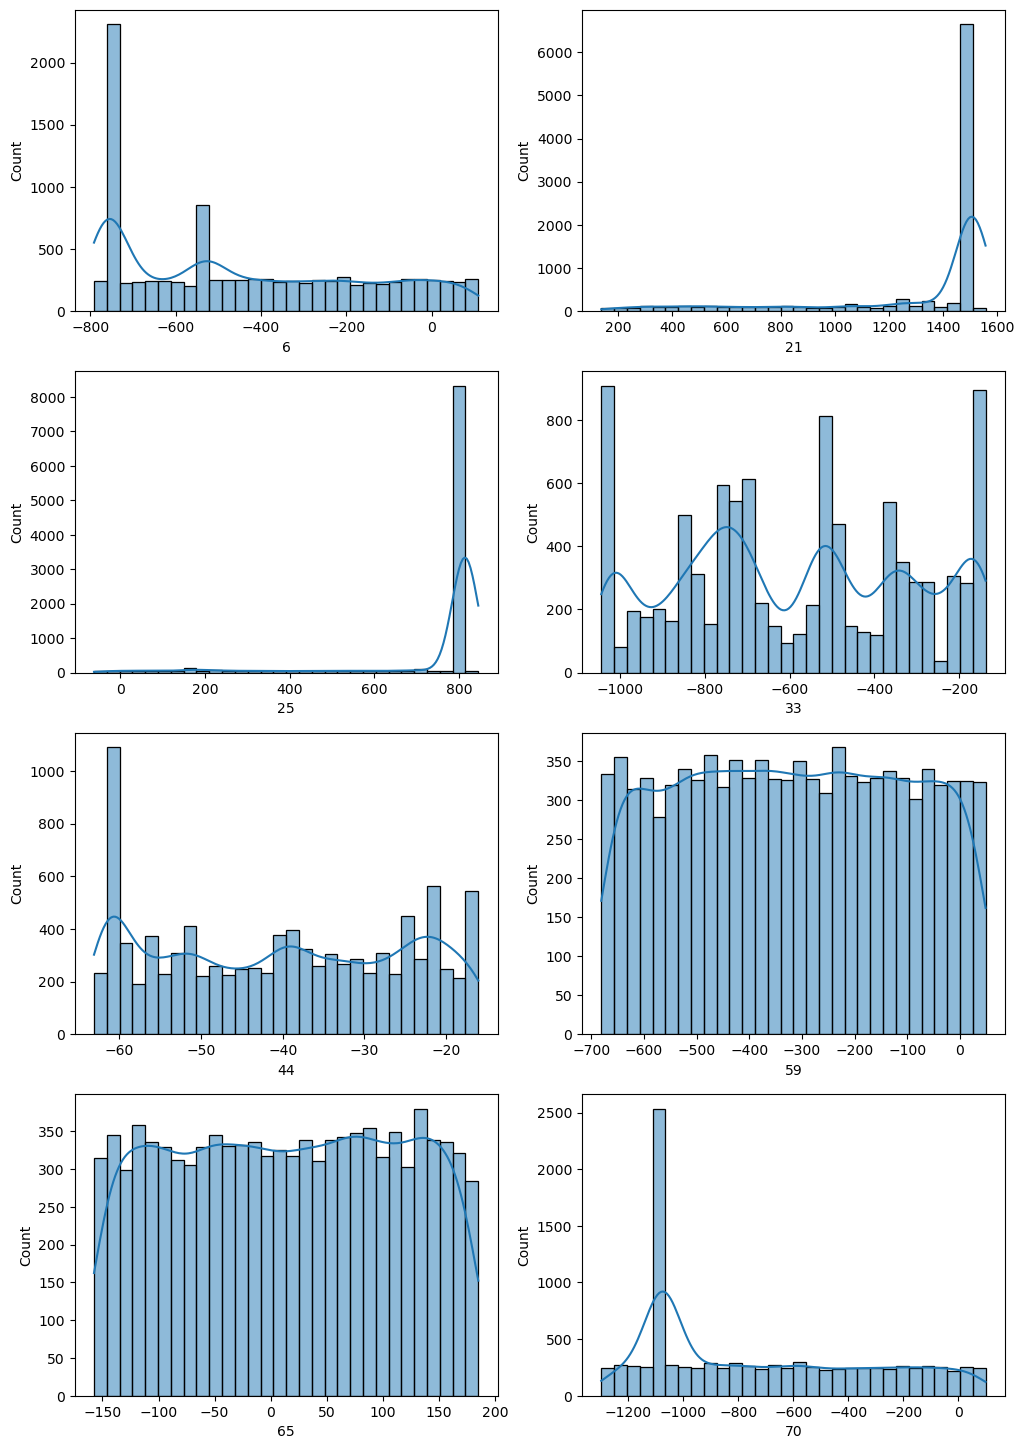

In [30]:
f, axs = plt.subplots(round(base[col_list].shape[1] / 2), 2, figsize=(12, 18))
j = 0
for i, col in enumerate(col_list):
    if (i%2 == 0) & (i != 0) : j += 1
    sns.histplot(base[col], bins=30, kde=True, ax=axs[j, i%2]);

## Масштабируем признаки

**Зададим набор методов преобразования/масштабирования**

In [31]:
stsc = StandardScaler()
mmsc = MinMaxScaler()
rbsc = RobustScaler()
pt = PowerTransformer()
scalers = [stsc, mmsc, rbsc, pt]

**Определим метод, обеспечивающий наибольшее значение метрики**

In [32]:
accuracies = pd.DataFrame(columns=['scaler', 'accuracy@5'])
for scaler in scalers:
    scaler.fit(base)
    train_features_sc = pd.DataFrame(scaler.transform(train_features),
                                     columns=train_features.columns,
                                     index=train_features.index)

    base_sc = pd.DataFrame(scaler.transform(base),
                           columns=base.columns,
                           index=base.index)

    train_features_sc = train_features_sc.drop(col_list, axis=1)
    base_sc = base_sc.drop(col_list, axis=1)

    dim = base_sc.shape[1]
    quantiser_sc = faiss.IndexFlatL2(dim)
    index_sc = faiss.IndexIVFFlat(quantiser_sc, dim, n_cells)
    index_sc.train(np.ascontiguousarray(base_sc.values).astype('float32'))

    index_sc.add(np.ascontiguousarray(base_sc.values).astype('float32'))

    distances_sc, indices_sc = index_sc.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                               top_n)
    accuracy = accuracy_top_n(train_target, indices_sc)
    accuracies = pd.concat([accuracies,
                          pd.DataFrame([[scaler, accuracy]],
                                        columns=accuracies.columns)], ignore_index=True)

/root/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/root/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


In [33]:
accuracies

,scaler,accuracy@5
0,StandardScaler(),85.14
1,MinMaxScaler(),85.10
2,RobustScaler(),85.13
3,PowerTransformer(),85.15


Лучшая метрика поиска  достигнута с использованием метода StandardScaler()

### Подберем количество кластеров

In [34]:
n_cells = round(base.shape[0]**0.5)
n_probe = round(n_cells * 0.2)
top_n = 5
print(n_cells, n_probe)

99 20


In [35]:
stats = pd.DataFrame(columns=['n_cells', 'n_probe', 'accuracy@{}'.format(top_n), 'time'])
start = round((base.shape[0]**0.5) * 0.2)
stop = round(base.shape[0]**0.5)
scaler = StandardScaler()

scaler.fit(base)
train_features_sc = pd.DataFrame(scaler.transform(train_features),
                                 columns=train_features.columns,
                                 index=train_features.index)
base_sc = pd.DataFrame(scaler.transform(base),
                       columns=base.columns,
                       index=base.index)

train_features_sc = train_features_sc.drop(col_list, axis=1)
base_sc = base_sc.drop(col_list, axis=1)

dim = base_sc.shape[1]

for n_cell in np.linspace(start, stop, num=10, endpoint=True):
    
    n_probe = round(int(n_cell) * 0.2)
    quantiser = faiss.IndexFlatL2(dim)
    start_time = datetime.datetime.now()
    
    
    index = faiss.IndexIVFFlat(quantiser, dim, int(n_cell))
    index.train(np.ascontiguousarray(base_sc.values).astype('float32'))

    index.add(np.ascontiguousarray(base_sc.values).astype('float32'))
    index.nprobe = n_probe
    
    train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                                  top_n)
    end_time = datetime.datetime.now()
    
    stats = pd.concat([stats, pd.DataFrame([[int(n_cell), 
                                            n_probe, 
                                            accuracy_top_n(train_target, train_indices), 
                                            (end_time - start_time).total_seconds()]], columns=stats.columns)], 
                      ignore_index=True)

In [36]:
stats

,n_cells,n_probe,accuracy@5,time
0,20,4,82.71,0.067124
1,28,6,83.42,0.080834
2,37,7,83.43,0.081299
3,46,9,83.60,0.084815
4,55,11,83.84,0.090832
5,63,13,83.84,0.098096
6,72,14,83.92,0.086269
7,81,16,83.82,0.091028
8,90,18,83.87,0.092377
9,99,20,84.03,0.099174


Разбиение выборки на количество кластеров, равное квадратному корню из количества объектов в выборке для поиска и количеством рассматриваемых кластеров равным 20% от общего количества кластеров, имеют самую высокую метрику и допустимое время работы.

### Уменьшение размерности

In [37]:
reduce_dim = 50

In [38]:
pca_matrix = faiss.PCAMatrix(dim, reduce_dim, 0, False)

sub_index = faiss.IndexFlatL2(reduce_dim)

In [39]:
index_pca = faiss.IndexPreTransform(pca_matrix, sub_index)

In [40]:
index_pca.train(np.ascontiguousarray(base_sc.values).astype('float32'))

In [41]:
index_pca.add(np.ascontiguousarray(base_sc.values).astype('float32'))

In [42]:
%%time
train_distances, train_indices = index_pca.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                                  top_n)

CPU times: user 564 ms, sys: 0 ns, total: 564 ms
Wall time: 142 ms


In [43]:
print('accuracy@{}: '.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@5:  84.69


Вариант поиска с уменьшением размерности показывает сравнимый результат с поиском при использовании кластеризации.

## Применение выбранных  методов на всех данных

### Поиск топ 5 с кластеризацией

In [44]:
base_index = {k: v for k, v in enumerate(all_base.index.to_list())}
train_target = all_train['Target']
train_features = all_train.drop('Target', axis=1)
scaler = StandardScaler()

scaler.fit(all_base)
train_features_sc = pd.DataFrame(scaler.transform(train_features),
                                 columns=train_features.columns,
                                 index=train_features.index)
base_sc = pd.DataFrame(scaler.transform(all_base),
                       columns=all_base.columns,
                       index=all_base.index)

train_features_sc = train_features_sc.drop(col_list, axis=1)
base_sc = base_sc.drop(col_list, axis=1)
dim = base_sc.shape[1]

quantiser = faiss.IndexFlatL2(dim)
index = faiss.IndexIVFFlat(quantiser, dim, n_cells)

index.train(np.ascontiguousarray(base_sc.values).astype('float32'))
index.add(np.ascontiguousarray(base_sc.values).astype('float32'))
index.nprobe = n_probe

In [45]:
%%time
train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                              top_n)

CPU times: user 29min 43s, sys: 590 ms, total: 29min 44s
Wall time: 7min 33s


In [46]:
print('accuracy@{}: '.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@5:  70.846


### Поиск топ 5 с уменьшением размерности

In [47]:
reduce_dim = 50

pca_matrix = faiss.PCAMatrix(dim, reduce_dim, 0, False)
sub_index = faiss.IndexFlatL2(reduce_dim)

index_pca = faiss.IndexPreTransform(pca_matrix, sub_index)

index_pca.train(np.ascontiguousarray(base_sc.values).astype('float32'))

index_pca.add(np.ascontiguousarray(base_sc.values).astype('float32'))

In [48]:
%%time
train_distances_pca, train_indices_pca = index_pca.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                                          top_n)

CPU times: user 23min 48s, sys: 8.47 s, total: 23min 56s
Wall time: 6min


In [49]:
print('accuracy@{}: '.format(top_n), accuracy_top_n(train_target, train_indices_pca))

accuracy@5:  70.55


Методы поиска с кластеризацией и уменьшением размерности как и на подвыборке показали сравнимый результат. Примем за основной метод с кластеризацией.

Метод поиска схожих векторов выдает на тренировочной выборке результат 70%. Целесообразно исследовать возможность повышения точности поиска путем последующего применения ранжирующей модели машинного обучения. Для этого найдем топ 50, 100, 200, 400 ближайших векторов.

### Поиск топ 50 векторов выбранным методом

In [50]:
top_n = 50

In [51]:
%%time
train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                 top_n)

CPU times: user 29min 36s, sys: 691 ms, total: 29min 37s
Wall time: 7min 30s


In [52]:
print('accuracy@{}'.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@50 78.321


In [53]:
# np.save('dumps/train_distances_{}'.format(top_n), train_distances)
# np.save('dumps/train_indices_{}'.format(top_n), train_indices)

### Поиск топ 100 векторов выбранным методом

In [54]:
top_n = 100

In [55]:
%%time
train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                 top_n)

CPU times: user 29min 35s, sys: 560 ms, total: 29min 36s
Wall time: 7min 30s


In [56]:
print('accuracy@{}'.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@100 79.976


In [57]:
# np.save('dumps/train_distances_{}'.format(top_n), train_distances)
# np.save('dumps/train_indices_{}'.format(top_n), train_indices)

## Найдем топ 200 векторов

In [58]:
top_n = 200

In [59]:
%%time
train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                 top_n)

CPU times: user 29min 30s, sys: 688 ms, total: 29min 31s
Wall time: 7min 30s


In [60]:
print('accuracy@{}'.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@200 81.501


In [61]:
# np.save('dumps/train_distances_{}'.format(top_n), train_distances)
# np.save('dumps/train_indices_{}'.format(top_n), train_indices)

## Найдем топ 400 векторов

In [62]:
top_n = 400

In [63]:
%%time
train_distances, train_indices = index.search(np.ascontiguousarray(train_features_sc.values).astype('float32'),
                                 top_n)

CPU times: user 29min 35s, sys: 695 ms, total: 29min 36s
Wall time: 7min 34s


In [64]:
print('accuracy@{}'.format(top_n), accuracy_top_n(train_target, train_indices))

accuracy@400 82.915


In [65]:
# np.save('dumps/train_distances_{}'.format(top_n), train_distances)
# np.save('dumps/train_indices_{}'.format(top_n), train_indices)

С увеличением числа ближайших векторов до 50 точность выросла ориентировочно на 8%. При увеличении числа ближайших векторов в интервале от 50 до 400 точность повышается незначительно, на 1-1,5% для каждого из интервалов (50:100, 100:200, 200:400).  

В рамках дальнейшего исследования проверим результат работы ранжирующей модели на выбоках из топ 50, 100, 200 и 400 векторов.

## Результат работы алгоритма на валидационной выборке

In [66]:
valid_features_sc = pd.DataFrame(scaler.transform(valid_features),
                                 columns=valid_features.columns,
                                 index=valid_features.index)

valid_features_sc = valid_features_sc.drop(col_list, axis=1)

In [67]:
top_n = 5

In [68]:
%%time
valid_distances, valid_indices = index.search(np.ascontiguousarray(valid_features_sc.values).astype('float32'),
                                              top_n)

CPU times: user 29min 22s, sys: 536 ms, total: 29min 22s
Wall time: 7min 31s


In [69]:
print('accuracy@{}: '.format(top_n), accuracy_top_n(valid_target['Expected'], valid_indices))

accuracy@5:  70.663


accuracy@5:  70.55

accuracy@50:  78.181

accuracy@100:  79.857

accuracy@200:  81.415

accuracy@400:  83.984

In [70]:
top_n = 100

In [71]:
%%time
valid_distances, valid_indices = index.search(np.ascontiguousarray(valid_features_sc.values).astype('float32'),
                                              top_n)

CPU times: user 29min 23s, sys: 704 ms, total: 29min 23s
Wall time: 7min 30s


In [72]:
# np.save('dumps/valid_distances_{}'.format(top_n), valid_distances)
# np.save('dumps/valid_indices_{}'.format(top_n), valid_indices)

На валидационной выборке алгоритм поиска ближайших векторов дает результат, сравнимый с результатом на тестовой выборке.

## Итог поиска ближайших векторов методом кластеризации

При начальных условиях, использовав исходные данные без обработки с количеством кластеров = 1 алгоритм поиска блиайших векторов показывает низкий результат и длительное время работы.

При анализе признаков выявлено, что большинство из них, за исключением 6, 21, 25, 33, 44, 59, 65, 70 имеют нормальное распределение с различным средним и дисперсией.

Для проверки возможности повышения качества поиска было применено:
* *масштабирование признаков* (применено несколько методов нормализации и трансформации признаков, лучший - StandardScaler);
* *подбор количества кластеров* (в пределе 0.2 от корня из общего количества векторов до корня из общего количества. Лучший результат получен при пазбиении выборки на количество кластеров, равное квадратному корню из количества объектов в выборке для поиска и количеством рассматриваемых кластеров равным 20% от общего их количества);
* *удаление признаков с распределением, отличным от нормального* (при удалении таких признаков точность поиска существенно возрастает).

Наряду с поиском ближайших векторов с использованием кластеризации рассмотрен вариант поиска с уменьшением размерности, который показывает сравнимый результат. За основной метод поиска выбран метод кластеризации. 

Выбранный метод поиска схожих векторов выдает на тренировочной выборке результат 70%. 
Целесообразно исследовать возможность повышения точности поиска путем последующего применения ранжирующей модели машинного обучения. Для этого также вычислены топ 50, 100, 200, 400 ближайших векторов.

С увеличением числа ближайших векторов до 50 точность выросла ориентировочно на 8%. При увеличении числа ближайших векторов в интервале от 50 до 400 точность повышается незначительно, на 1-1,5% для каждого из интервалов (50:100, 100:200, 200:400).  

В рамках дальнейшего исследования проверим результат работы ранжирующей модели на выбоках из топ 50, 100, 200 и 400 векторов.

На валидационной выборке использование выбранного алгоритма поиска ближайших векторов дает результат, сравнимый с результатом, полученным на тестовой выборке.